*First compiled on July, 3 2017.*

# Graph abstraction for 33k PBMC cells

In [1]:
import numpy as np
import scanpy.api as sc
import matplotlib.pyplot as pl

sc.settings.verbosity = 2                 # verbosity: 0=errors, 1=warnings, 2=info, 3=hints, ...
sc.settings.set_figure_params(dpi=100)    # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+21.g7c3f248.dirty on 2017-10-05 00:47.


### Load the data

In [3]:
def pbmc33k_raw():
    filename_data = './data/pbmc33k_filtered_gene_bc_matrices/hg19/matrix.mtx'
    filename_genes = './data/pbmc33k_filtered_gene_bc_matrices/hg19/genes.tsv'
    filename_barcodes = './data/pbmc33k_filtered_gene_bc_matrices/hg19/barcodes.tsv'
    filename_labels = './data/pbmc33k_seurat_celltypes.csv'
    adata = sc.read(filename_data, cache=True).transpose()
    adata.var_names = np.loadtxt(filename_genes, dtype=str)[:, 1]
    adata.smp_names = np.loadtxt(filename_barcodes, dtype=str)
    # cell_types = np.loadtxt(filename_labels, delimiter='\t', dtype='S')
    # adata.smp['cell_types'] = cell_types
    return adata

def pbmc33k_seurat():
    filename_data = './data/pbmc33k_seurat/pbmc33k_seurat_pca_x.txt'
    filename_anno = './data/pbmc33k_seurat/pbmc33k_seurat_anno.txt'
    adata = sc.read(filename_data, cache=True)
    annotation = np.genfromtxt(filename_anno, dtype=str)
    adata.smp['tSNE1_seurat'] = annotation[1:, 1].astype(float)
    adata.smp['tSNE2_seurat'] = annotation[1:, 2].astype(float)
    adata.smp['cell_types_seurat'] = [n.strip('"') for n in annotation[1:, 3]]
    return adata

Use data that has been preprocessed with Seurat.

In [6]:
adata_seurat = pbmc33k_seurat()

reading file ./write/data/pbmc33k_seurat/pbmc33k_seurat_pca_x.h5


### Visualization

Compare Scanpy's tSNE with Seurat's tSNE.

In [8]:
sc.tl.tsne(adata_seurat)

computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:02:18.643) and added
    "X_tsne", tSNE coordinates (adata.smp)


... updating the color palette to provide enough colors


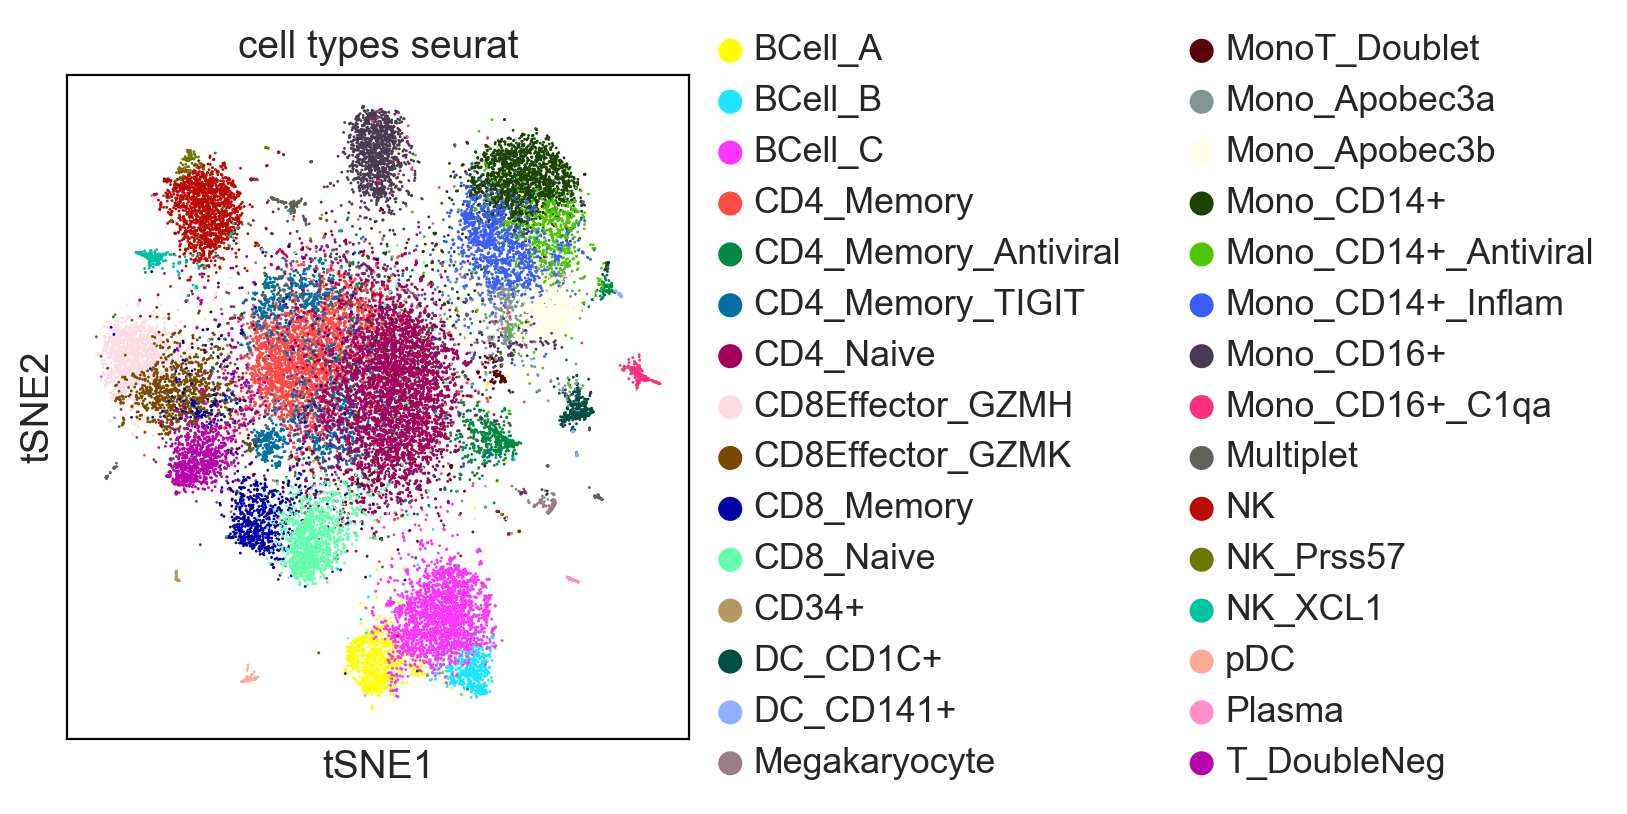

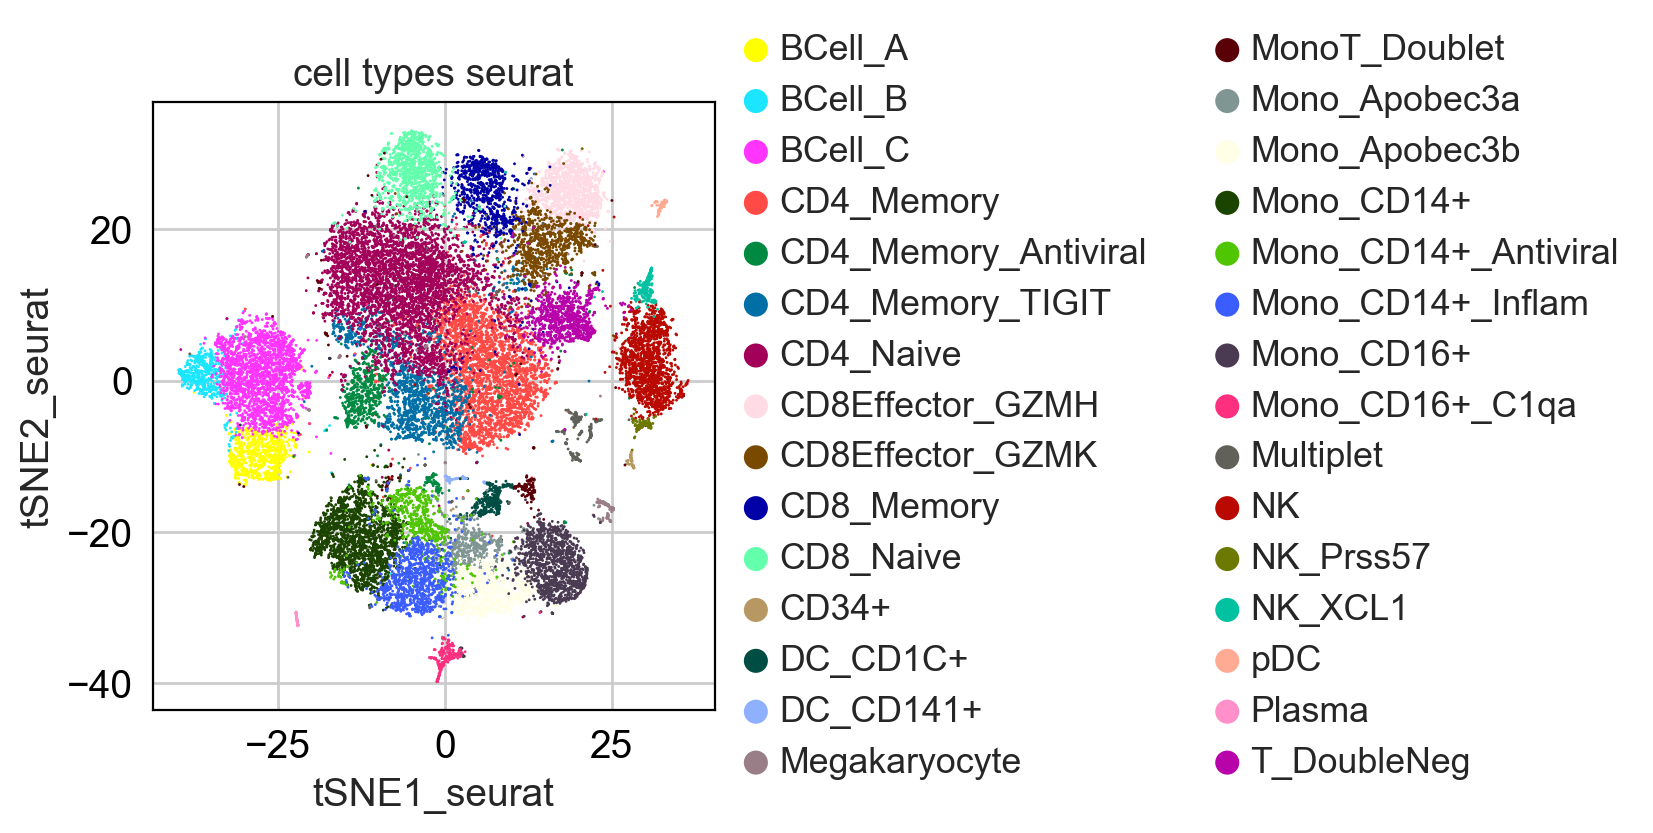

In [9]:
ax = sc.pl.tsne(adata_seurat, color='cell_types_seurat')
ax = sc.pl.scatter(adata_seurat, x='tSNE1_seurat', y='tSNE2_seurat', color='cell_types_seurat')

### Filter out a few cells about which we don't know anything

In [10]:
filter_cells = np.zeros(adata_seurat.n_smps, dtype=bool)
print('for comparison:', np.unique(adata_seurat.smp['cell_types_seurat']))
for accept in ['CD34+', 'CD4_Memory', 'CD4_Memory_Antiviral',
               'CD4_Memory_TIGIT', 'CD4_Naive', 'CD8Effector_GZMH', 
               'CD8Effector_GZMK',
               'CD8_Memory', 'CD8_Naive', 'DC_CD141+', 'DC_CD1C+',
               'Mono_CD14+', 'Mono_CD14+_Antiviral', 
               'Mono_CD14+_Inflam', 'Mono_CD16+', 'Mono_CD16+_C1qa']:
    filter_cells[adata_seurat.smp['cell_types_seurat'] == accept] = True
adata_red = adata_seurat[filter_cells, :]
del adata_red.add['cell_types_seurat_order']
sc.write('pbmc33k_seurat_red', adata_red)

for comparison: ['BCell_A' 'BCell_B' 'BCell_C' 'CD34+' 'CD4_Memory' 'CD4_Memory_Antiviral'
 'CD4_Memory_TIGIT' 'CD4_Naive' 'CD8Effector_GZMH' 'CD8Effector_GZMK'
 'CD8_Memory' 'CD8_Naive' 'DC_CD141+' 'DC_CD1C+' 'Megakaryocyte'
 'MonoT_Doublet' 'Mono_Apobec3a' 'Mono_Apobec3b' 'Mono_CD14+'
 'Mono_CD14+_Antiviral' 'Mono_CD14+_Inflam' 'Mono_CD16+' 'Mono_CD16+_C1qa'
 'Multiplet' 'NK' 'NK_Prss57' 'NK_XCL1' 'Plasma' 'T_DoubleNeg' 'pDC']
writing ./write/pbmc33k_seurat_red.h5


In [11]:
adata_red = sc.read('pbmc33k_seurat_red')
sc.tl.tsne(adata_red)

reading file ./write/pbmc33k_seurat_red.h5
computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:01:27.010) and added
    "X_tsne", tSNE coordinates (adata.smp)
writing ./write/pbmc33k_seurat_red.h5


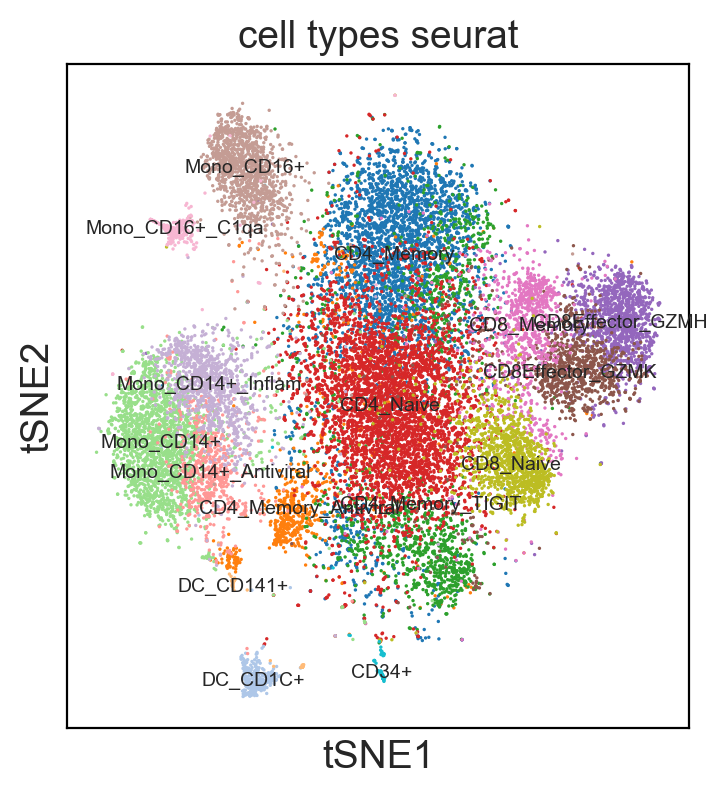

writing ./write/pbmc33k_seurat_red.h5


In [15]:
ax = sc.pl.tsne(adata_red, color='cell_types_seurat',
                legend_loc='on data', legend_fontsize=7)
sc.write('pbmc33k_seurat_red', adata_red)

## Graph abstraction

In [16]:
adata = sc.read('pbmc33k_seurat_red')
sc.tl.aga(adata, node_groups='cell_types_seurat')
sc.write('pbmc33k_seurat_red', adata)

reading file ./write/pbmc33k_seurat_red.h5
running Approximate Graph Abstraction (AGA)
    no root cell found, no computation of pseudotime
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9672636986  0.9569699764  0.9461995363  0.943002224
      0.9169313908  0.8999741077  0.8840186596  0.8824774623  0.8697708249]
    abstracted graph will have 16 nodes
... finished (0:00:23.836)
writing ./write/pbmc33k_seurat_red.h5


reading ./write/pbmc33k_seurat_red.h5
saving figure to file ./figures/aga_pbmc33k.png


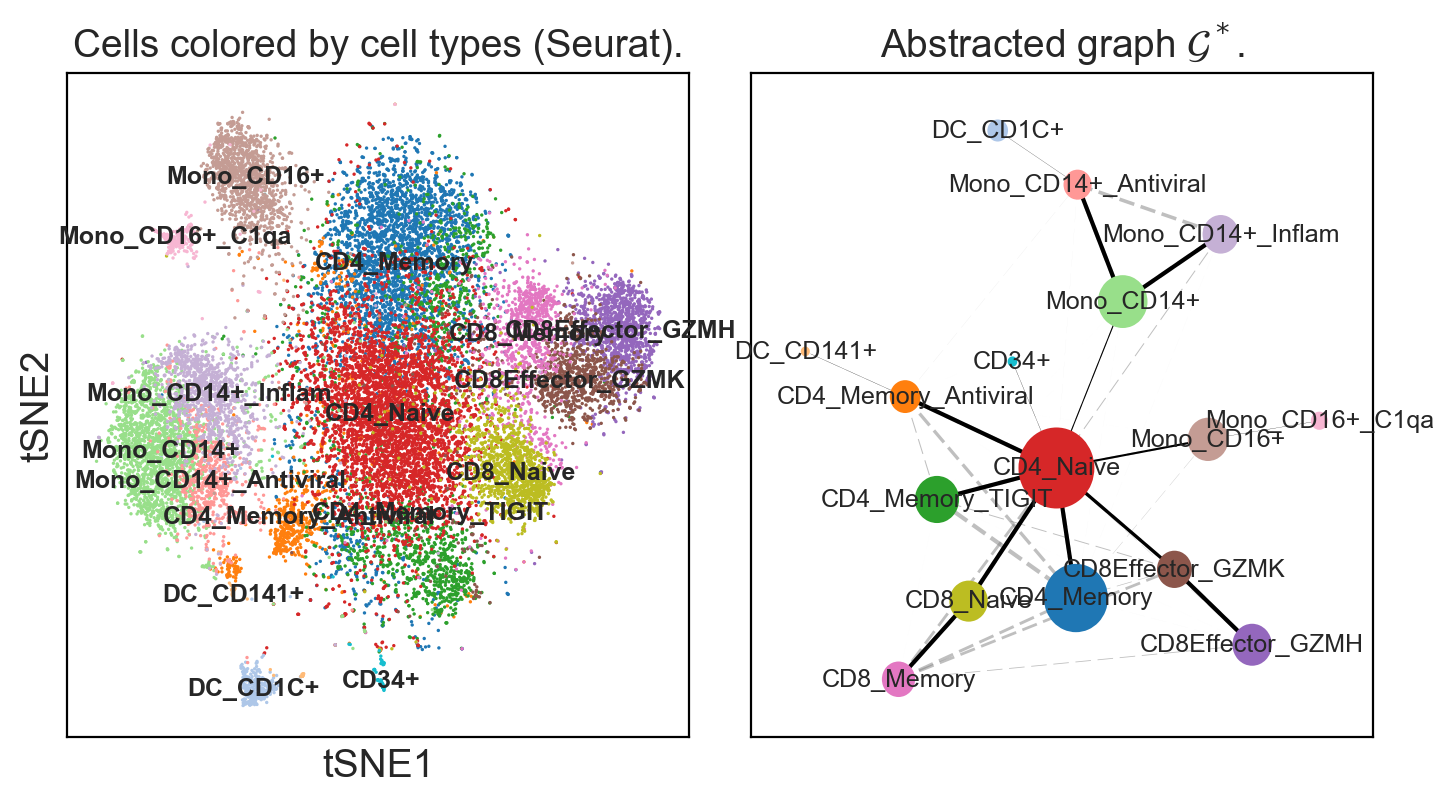

In [6]:
adata = sc.read('pbmc33k_seurat_red')
axs = sc.pl.aga(adata, legend_fontsize=9, legend_fontweight='bold', 
                title='Cells colored by cell types (Seurat).',
                title_graph='Abstracted graph $\mathcal{G}^*$.',
                fontsize=9,
                save='_pbmc33k')